__Papermils parameters__

In [25]:
FILL    = 8146
wiresON = True
SAVEPKL = 'wires_on'

---
---

# Lumi decrease

In [26]:
INTERACTIVE = False
FIGWIDTH    = 12
SAVING      = False

# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import sys
sys.path.append('../')

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)

# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
BMODE     = None#'STABLE'

# Importing fill data
database = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}')
database = database.sort_index()
database.index.name = 'unix'
database.insert(0,'Timestamp',database.index)
database.insert(1,'Time',1e-9*(database.index - database.index[0]))
database['Timestamp'] = database['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))



## Filling

Text(0.5, 0, 'Bunch number')

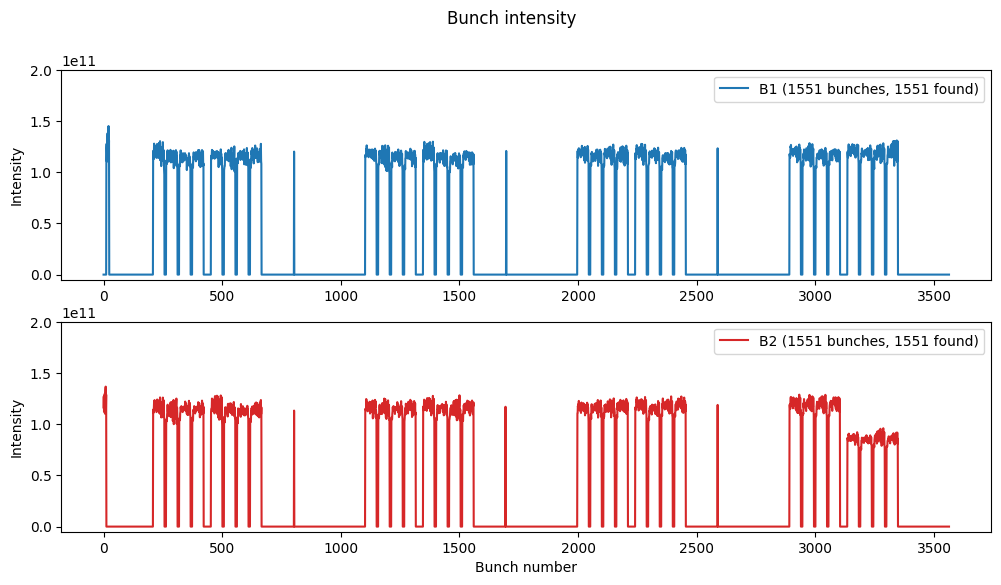

In [27]:
fig, axes = plt.subplots(figsize= (FIGWIDTH,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})

for beam,ax,color in zip(beams,axes,['C0','C3']):
    
    filled_ts = np.min(database[database[beam['Intensity']]== np.max(database[beam['Intensity']])].index)
    
    sub = database.dropna(subset=[beam['Nb']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    Nb        = int(database.loc[_ts,beam['Nb']])

    sub = database.dropna(subset=[beam['bb_Intensity']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    bunch_I   = database.loc[_ts,beam['bb_Intensity']]
    
    Nb_found = np.sum(bunch_I>0.5e11)

    plt.sca(ax)
    plt.plot(bunch_I,color=color,label = f'{beam.name} ({Nb} bunches, {Nb_found} found)')
    plt.legend()
    plt.ylim([-0.05e11,2e11])
    plt.ylabel('Intensity')
fig.suptitle('Bunch intensity')
plt.xlabel('Bunch number')


# ROI (Luminosity on)

2022-08-02 04:44:03.788487+00:00 | 2022-08-02 14:23:40.579015+00:00


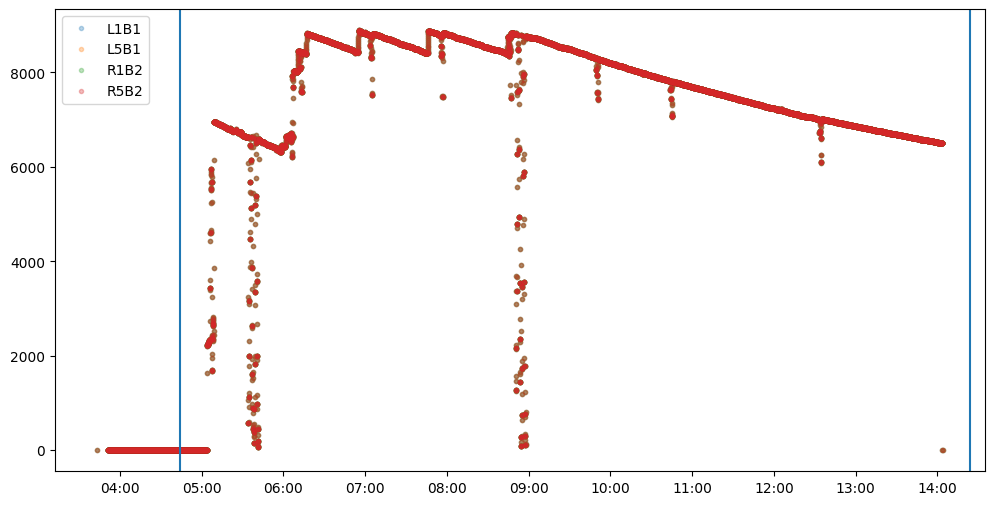

In [28]:
df = database.dropna(subset=[beams[0]['Luminosity']['ATLAS']])

start_ts = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].min()
stop_ts  = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()

if wiresON:
    df = database
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
else:
    wire_start,wire_stop = start_ts,stop_ts

start_ts,stop_ts = start_ts-pd.Timedelta(minutes=20),stop_ts+pd.Timedelta(minutes=20)
print(start_ts,'|',stop_ts)

plt.figure(figsize=(FIGWIDTH,6))
for wire in wires['B1']+wires['B2']:
    database.nxPlot('Timestamp',beams[0]['Luminosity']['ATLAS'],'.',alpha=0.3,label=wire.loc)
plt.axvline(start_ts)
plt.axvline(stop_ts)
plt.legend()

# Q Optimisation

In [18]:
data

unix
1658765788285000000   -0.00379
1658765822120000000   -0.00379
1658765856163380000   -0.00379
1658765890171903000   -0.00379
1658765924443011000   -0.00379
                        ...   
1658779675688000000    0.07481
1658779708610340000    0.07481
1658779740743598000    0.07481
1658779773058280000    0.07481
1658779805278429000    0.07481
Name: LhcStateTracker:LHCBEAM1:QH_TRIM:correction, Length: 463, dtype: float64

In [34]:
database.at_ts(STABLE_ts,ii,method='nearest',return_ts=False)

0.07682

Text(0, 0.5, 'Tune')

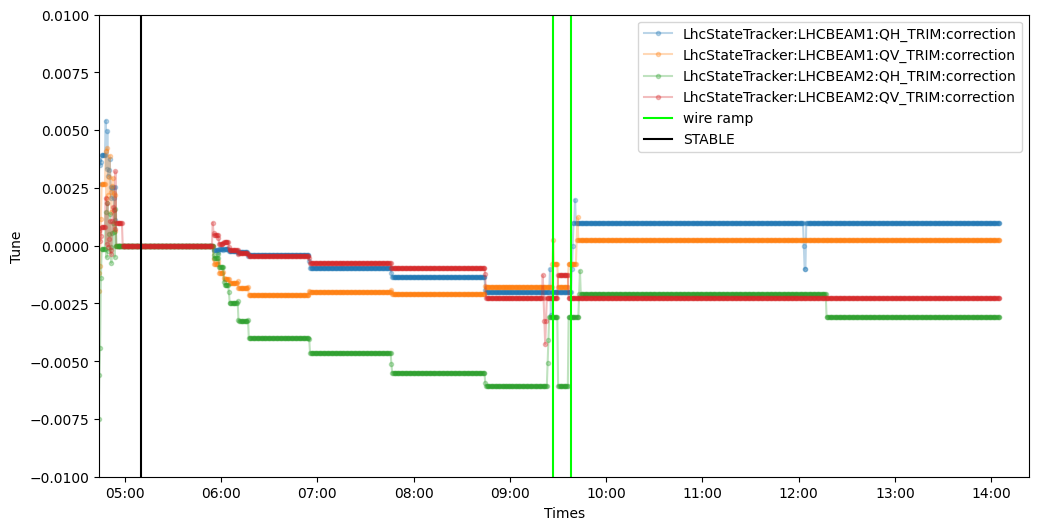

In [36]:

STABLE_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
STABLE_idx = database[database['HX:BMODE'] == 'STABLE'].index[0]

plt.figure(figsize=(FIGWIDTH,6))
for ii in ['LhcStateTracker:LHCBEAM1:QH_TRIM:correction',
           'LhcStateTracker:LHCBEAM1:QV_TRIM:correction',
           'LhcStateTracker:LHCBEAM2:QH_TRIM:correction',
           'LhcStateTracker:LHCBEAM2:QV_TRIM:correction']:
    

    time = database.set_index('Timestamp')[ii].dropna().index[0:-1:1000]
    data = database[ii].dropna().iloc[0:-1:1000]
    ref = database.at_ts(STABLE_ts,ii,method='nearest',return_ts=False)

    #database.nxPlot('Timestamp',ii,'.-',alpha=0.3,label=ii)
    plt.plot(time,data-ref,'.-',alpha=0.3,label=ii)
    #plt.plot(at.pandas_index_localize(data_df[ii].dropna().iloc[0:-1:1000]),'.-',label=ii)
plt.axvline(wire_start,color='lime')
plt.axvline(wire_stop,color='lime',label='wire ramp')

plt.axvline(STABLE_ts,color='k',label='STABLE')

plt.xlim([start_ts,stop_ts])
plt.ylim([-1e-2,1e-2])
plt.legend(loc='best')

plt.xlabel('Times')
plt.ylabel('Tune')

# Intensity b-by-bunch

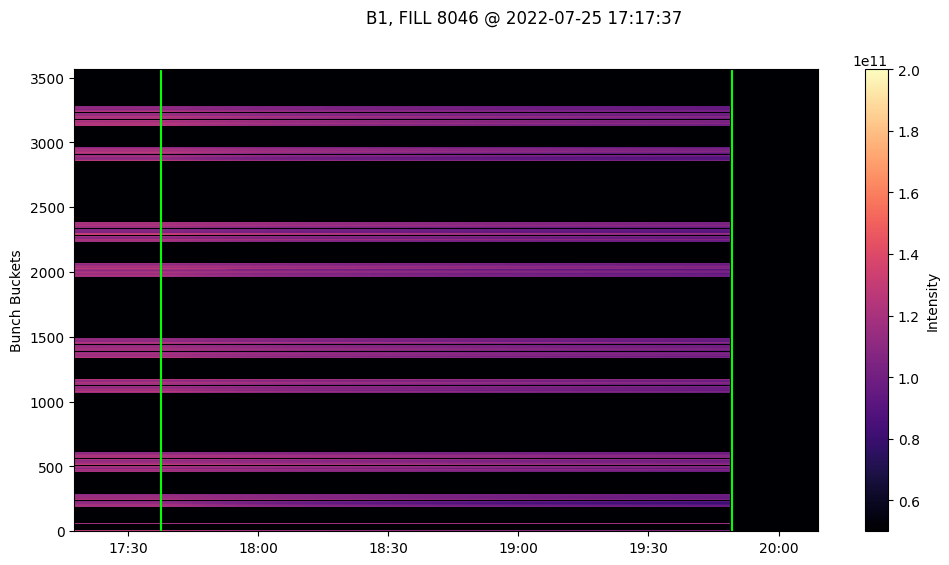

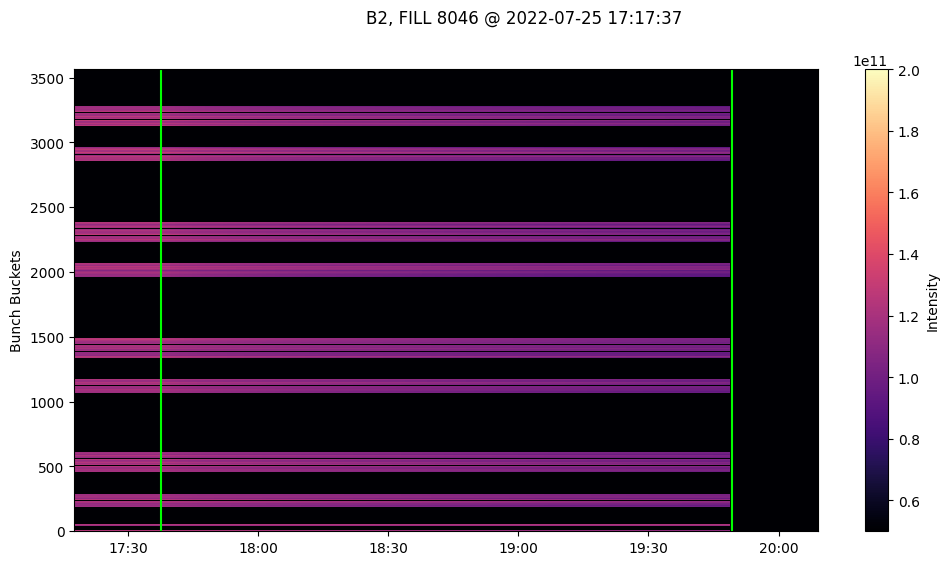

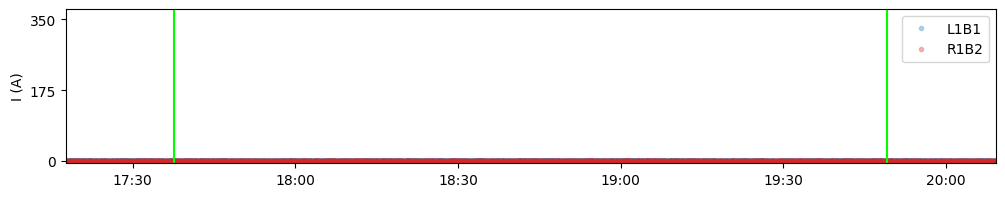

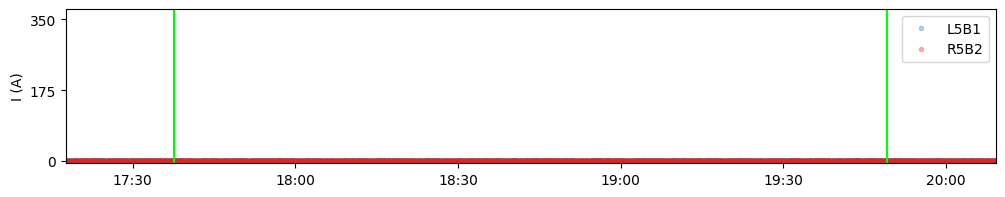

In [6]:

for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,6))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    # Averaging
    int_avg = database.bin(beam['bb_Intensity'],window=60)
    times,datagrid = int_avg.set_index('Timestamp')[beam['bb_Intensity']].to_2D()
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T,vmin=0.5e11, vmax=2e11,cmap='magma')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    
    cbar = plt.colorbar()
    cbar.set_label('Intensity')
    plt.ylabel('Bunch Buckets')
    plt.xlim([start_ts,stop_ts])



for _IP in ['IP1','IP5']:
    fig = plt.figure(figsize=(FIGWIDTH,2))
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')
    plt.legend()
    plt.xlim([start_ts,stop_ts])



# Lumi b-by-b

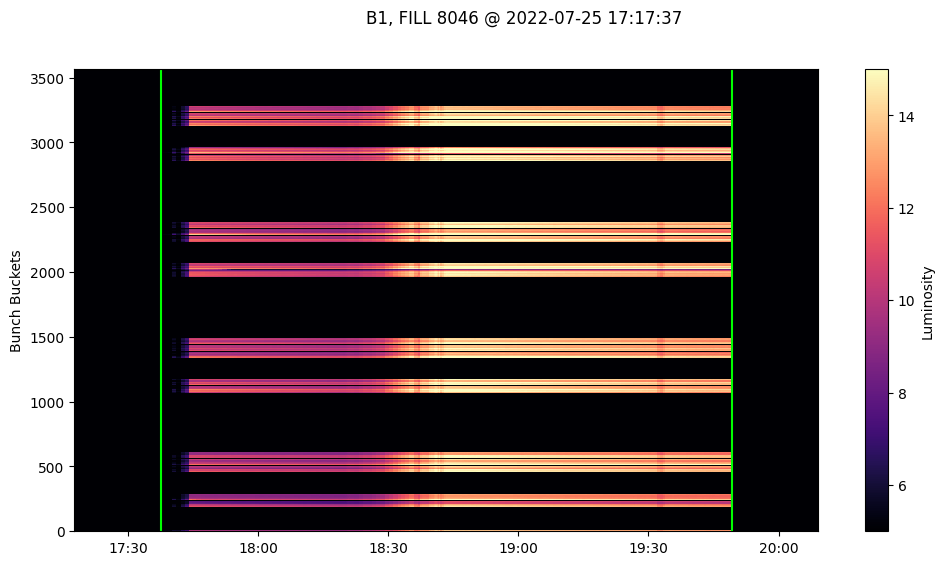

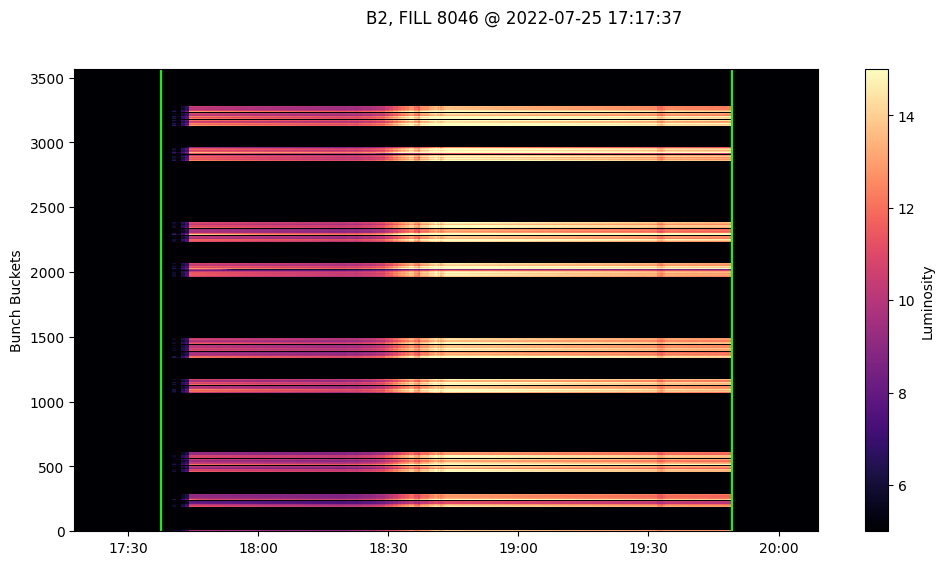

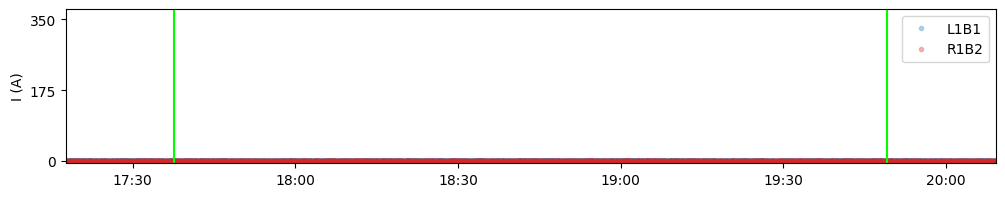

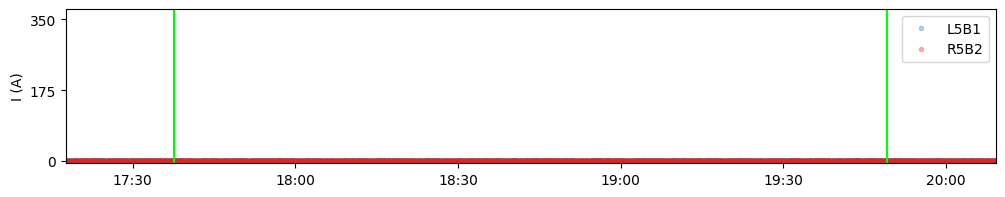

In [7]:
from scipy.interpolate import interp1d

# COMPUTING LHCB BB-LUMI:
injection_scheme = database['LHC.STATS:LHC:INJECTION_SCHEME'].iloc[0]
nb_coll = {'ATLAS':int(injection_scheme.split('_')[2]),'CMS':int(injection_scheme.split('_')[2]),'LHCB':int(injection_scheme.split('_')[4]),'ALICE':int(injection_scheme.split('_')[3])}

nb_coll = {'ATLAS':len(buckets),'CMS':len(buckets),'LHCB':len(buckets),'ALICE':len(buckets)}

try:
    for loc in ['ALICE','LHCB']:    
        database.insert(5,f'{loc}:BUNCH_LUMI_INST',database[beams[0]['bb_Luminosity']['ATLAS']])

        times         = database[beams[0]['bb_Luminosity']['ATLAS']].dropna().index
        interp_values = np.interp(times, database[f'{loc}:LUMI_TOT_INST'].dropna().index ,database[f'{loc}:LUMI_TOT_INST'].dropna()/nb_coll[loc])
        database.loc[times,f'{loc}:BUNCH_LUMI_INST'] = database[beams[0]['bb_Luminosity']['ATLAS']].dropna()*0 + interp_values
except:
    pass

# COMPUTING LUMI TOT
#============================
try:
    database.insert(4,'bb_LUMI_TOT',database[beams[0]['bb_Luminosity']['ATLAS']])
except:
    database['bb_LUMI_TOT'] = database[beams[0]['bb_Luminosity']['ATLAS']].copy()


times,lumi_tot  = database['bb_LUMI_TOT'].to_2D()
for loc in ['ALICE','CMS','LHCB']:
    times_found,allBunches = database[beams[0]['bb_Luminosity'][loc]].to_2D()

    lumi_tot   += interp1d(times_found,allBunches,axis=0)(times)

database.loc[times,'bb_LUMI_TOT'] = pd.DataFrame({'tmp':list(lumi_tot)},index=times)['tmp']

#============================



for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,6))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    
    times,datagrid = database.set_index('Timestamp')['bb_LUMI_TOT'].to_2D()
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T,vmin=5, vmax=15,cmap='magma')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    
    cbar = plt.colorbar()
    cbar.set_label('Luminosity')
    plt.ylabel('Bunch Buckets')
    plt.xlim([start_ts,stop_ts])



for _IP in ['IP1','IP5']:
    fig = plt.figure(figsize=(FIGWIDTH,2))
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')
    plt.legend()
    plt.xlim([start_ts,stop_ts])

# Lifetime b-by-b

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarn

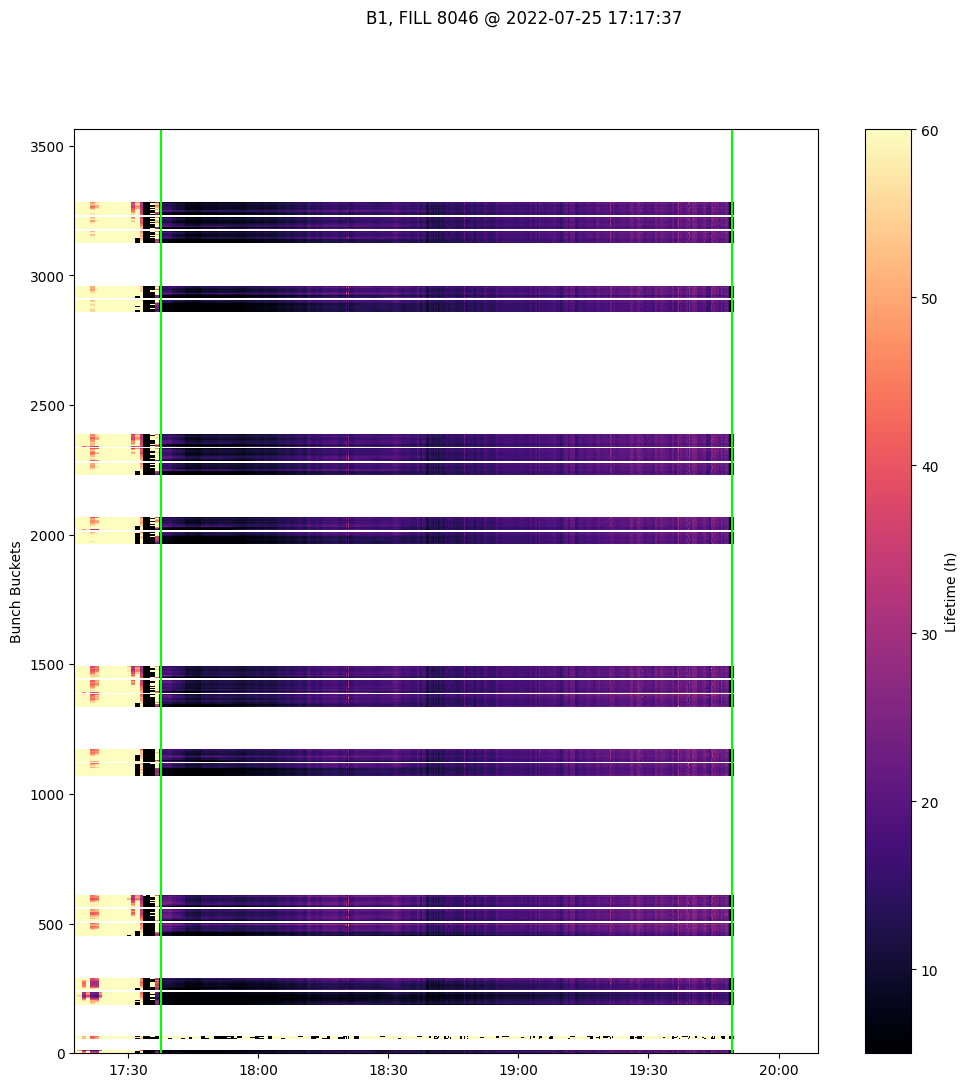

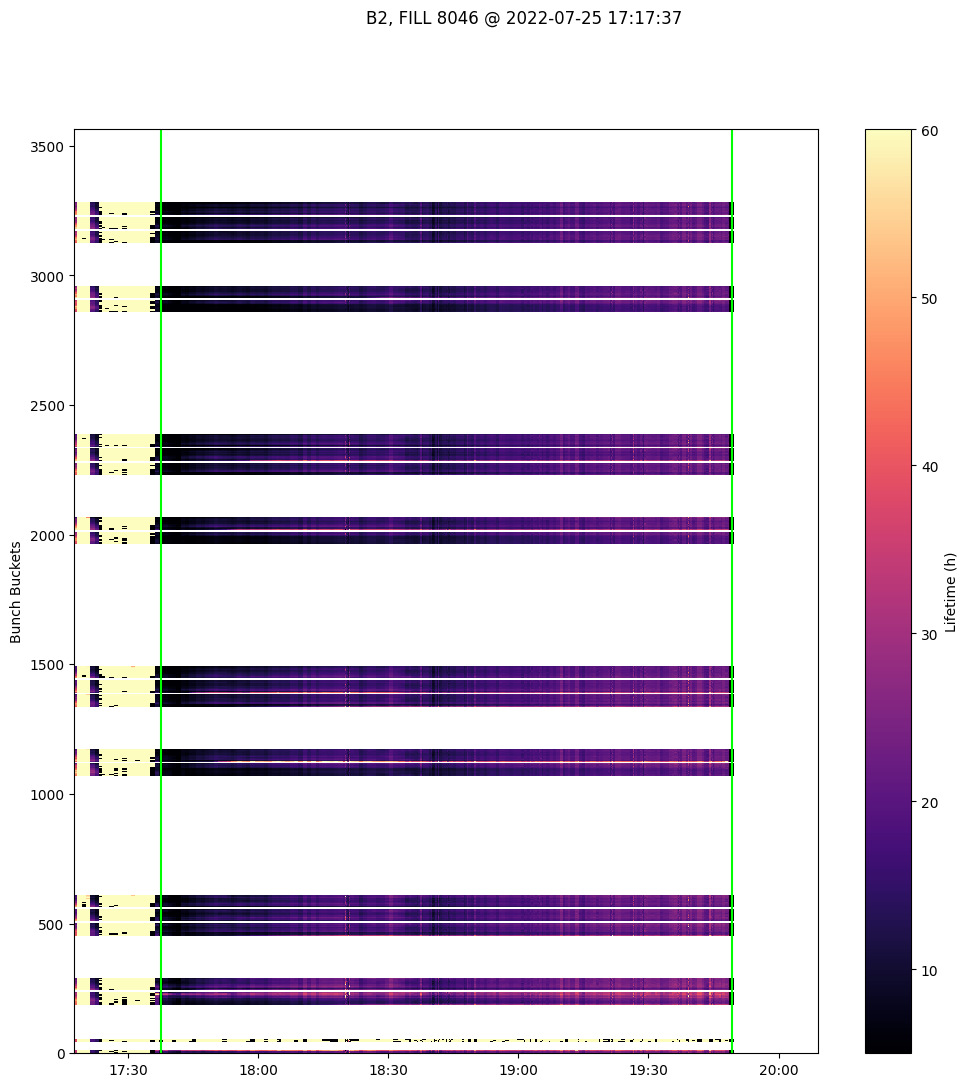

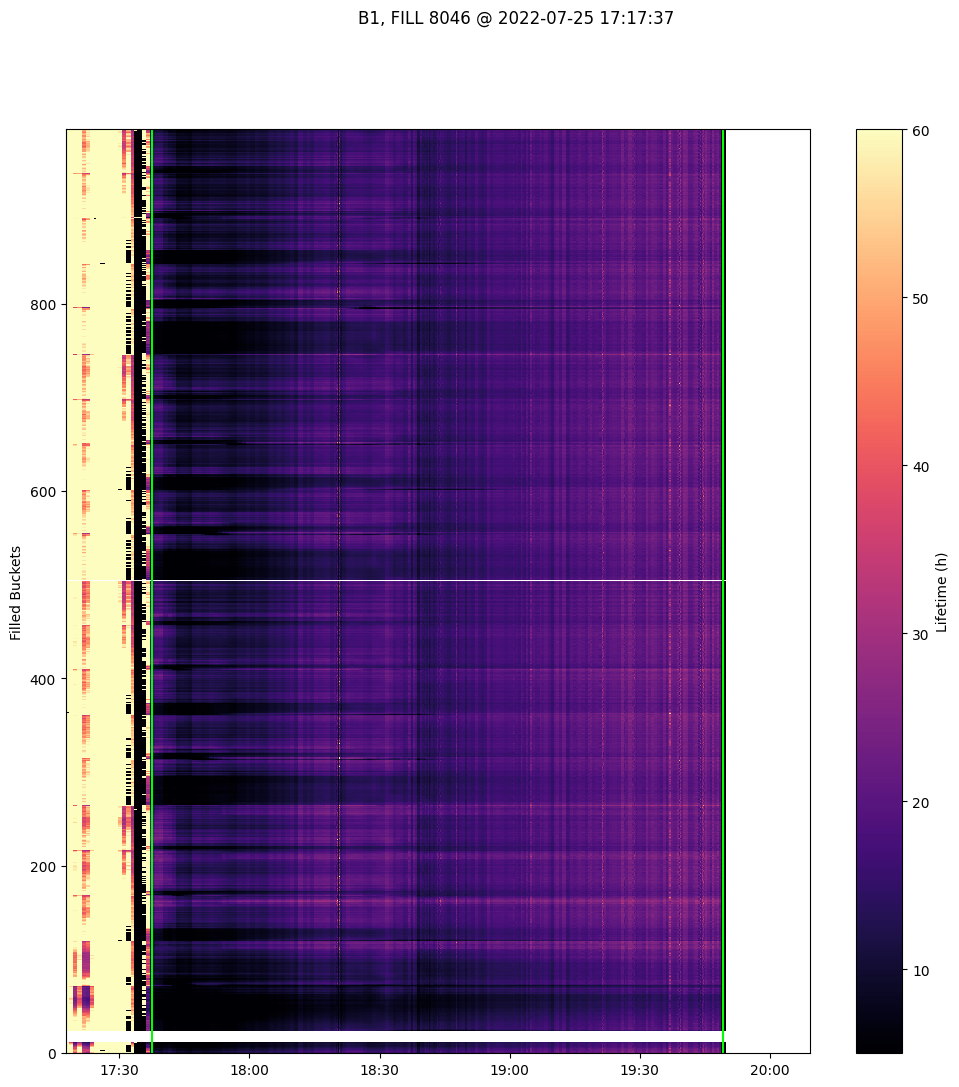

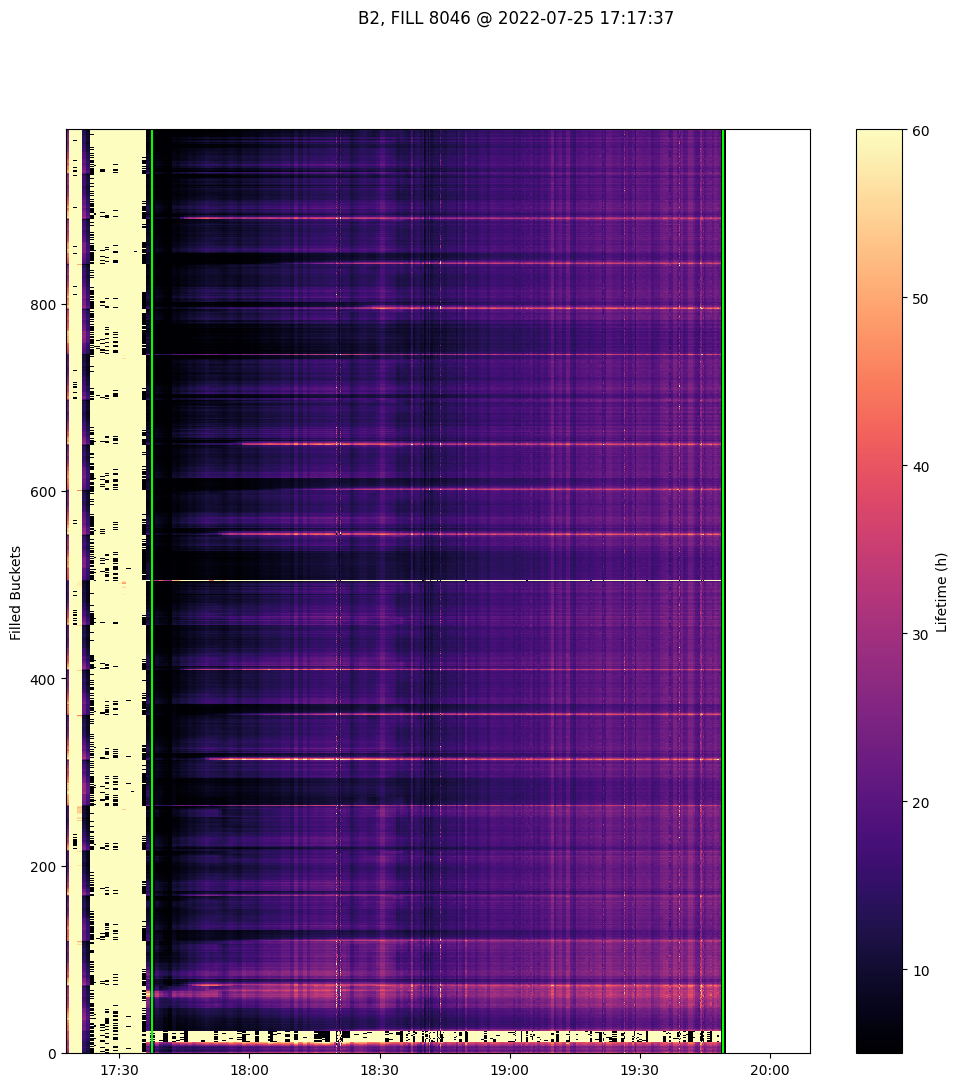

In [8]:
def compute_lifetime_avg(df,beam):

    
    # Extracting quantities:
    #----------------------------------------
    # Luminosity is measured every minute, let's use it without too much manipulations
    times = df.set_index('Time')['bb_LUMI_TOT'].dropna().index
    bins  = np.diff(times)/2 + times[:-1]

    observable     = beam['bb_Intensity']
    times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].to_2D()

    observable  = 'bb_LUMI_TOT'
    _,data_L    = df.set_index('Time')[observable].to_2D()
    data_L      = 1e6*data_L[2:-2,:]
    times       = times[2:-2]
    #----------------------------------------

    # Aligning times with interpolation
    #---------------------------------
    data_N = interp1d(times_N,data_N,axis=0)(times)
    #---------------------------------

    # Computing xsection and lifetime
    #---------------------------------
    dNdt      = np.diff(data_N,axis=0)/np.tile(np.diff(times),(np.shape(data_N)[1],1)).T
    #xsection  = -dNdt/data_L[:-1,:]
    #N0        = np.tile(data_N[0,:],(np.shape(data_N)[0],1))
    lifetime  = -data_N[:-1,:]/dNdt
    #---------------------------------


    # UNPACKING RESULTS
    bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]


    return pd.DataFrame({'Time':times[:-1],'Timestamp':bin_timestamp[:-1],'Lifetime':list(lifetime)},index=bin_unix[:-1])




for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_lifetime_avg(database,beam)
    
    if SAVING:
        lifetime_df.to_pickle(f"../Results_Lumi_bb/{SAVEPKL}/Lifetime_F{FILL}_{beam.name}.pkl")
        
    times,datagrid = lifetime_df.set_index('Timestamp')['Lifetime'].to_2D()

    #datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/3600,vmin=5, vmax=60,cmap='magma')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')

    cbar = plt.colorbar()
    cbar.set_label('Lifetime (h)')
    plt.ylabel('Bunch Buckets')
    plt.xlim([start_ts,stop_ts])

for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    
    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_lifetime_avg(database,beam)
    
    times,datagrid = lifetime_df.set_index('Timestamp')['Lifetime'].to_2D()

    datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/3600,vmin=5, vmax=60,cmap='magma')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime') 
    
    cbar = plt.colorbar()
    cbar.set_label('Lifetime (h)')
    plt.ylabel('Filled Buckets')
    plt.xlim([start_ts,stop_ts])



# Effective cross section

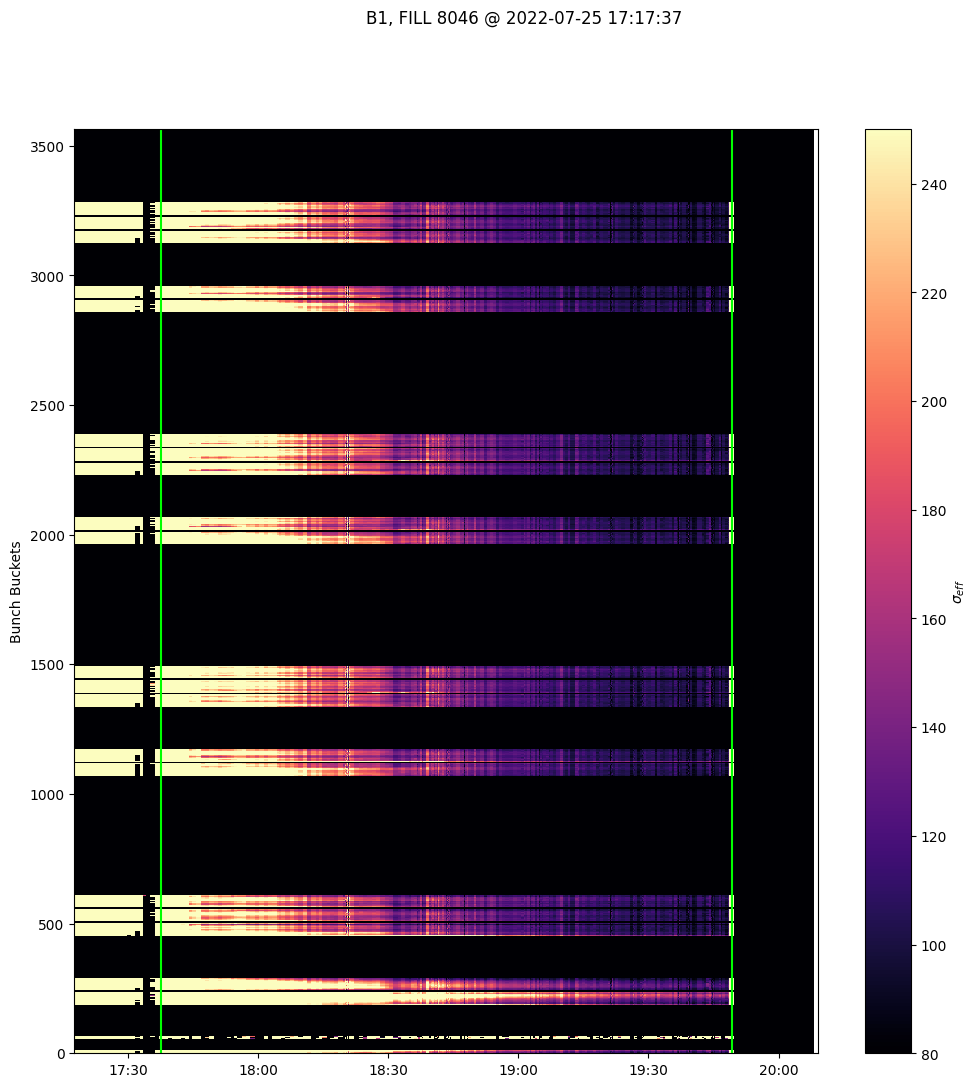

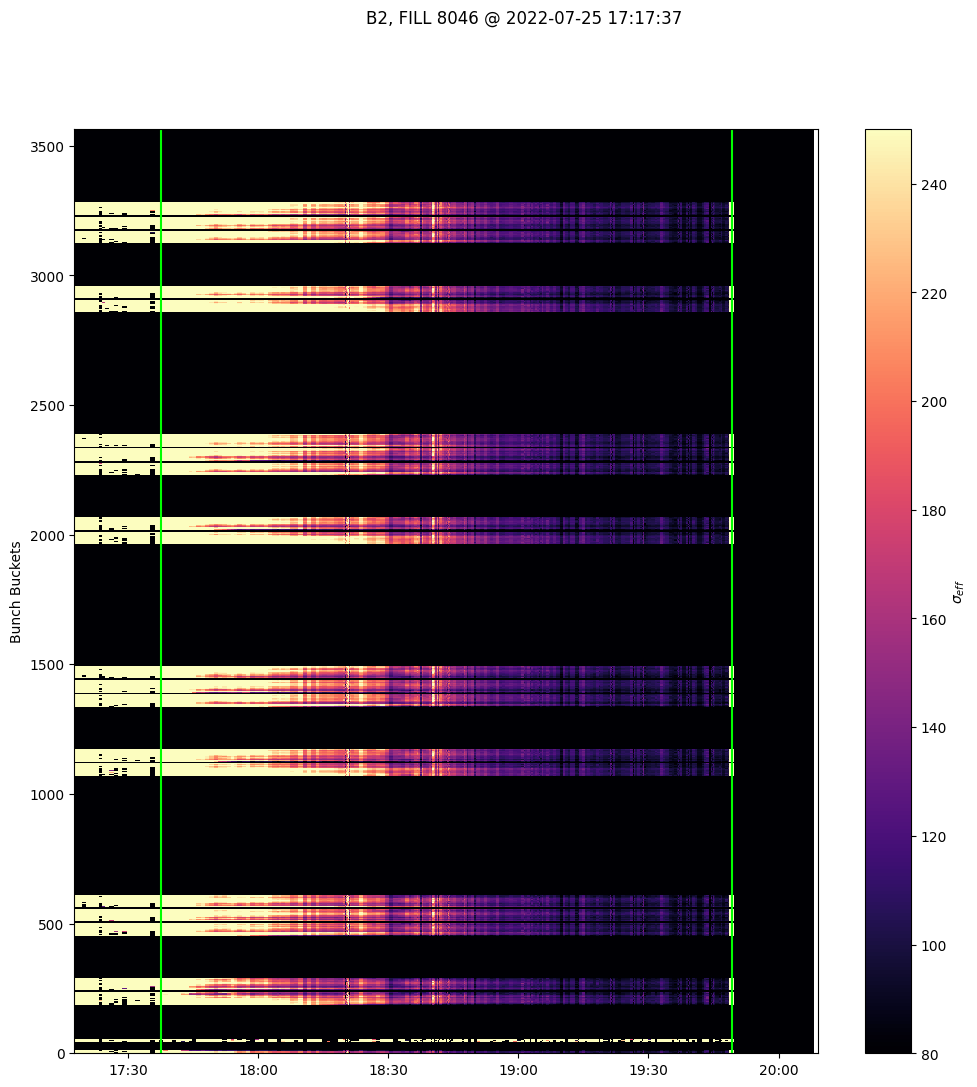

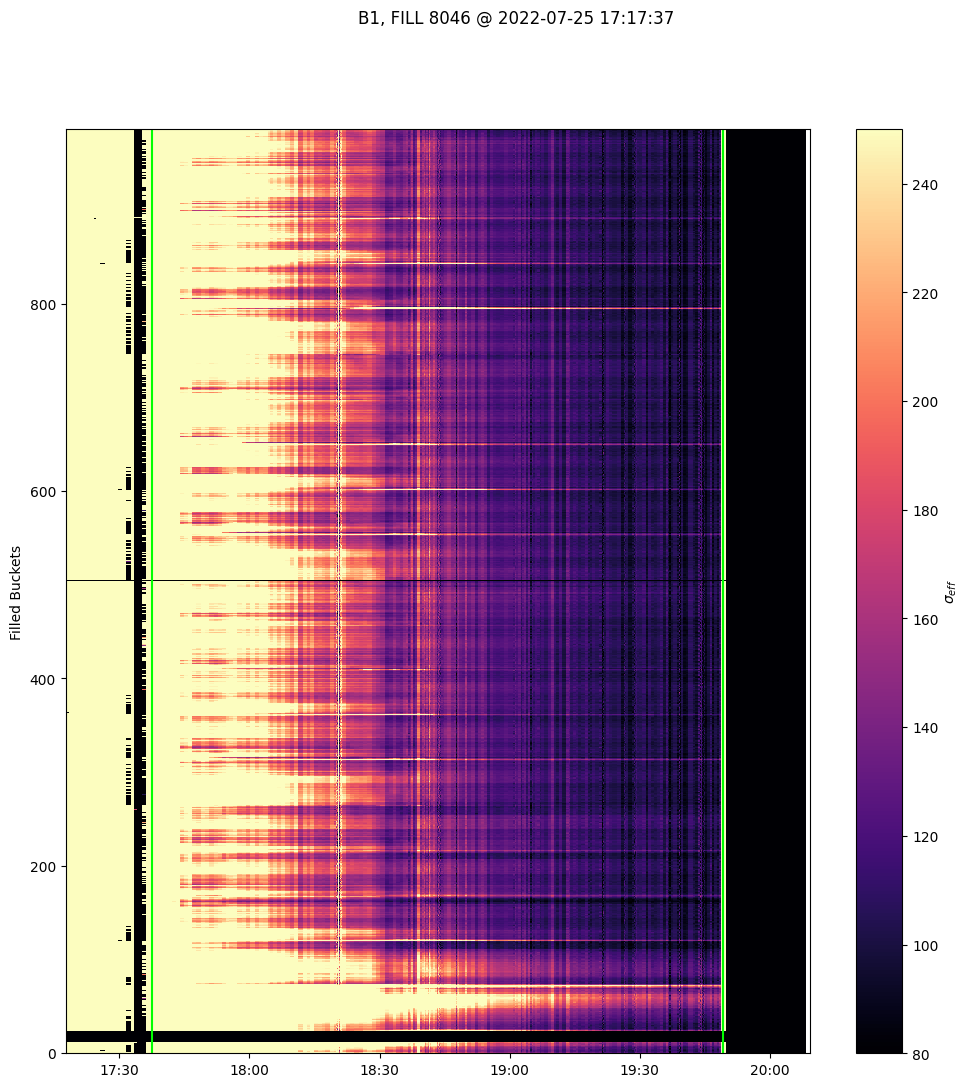

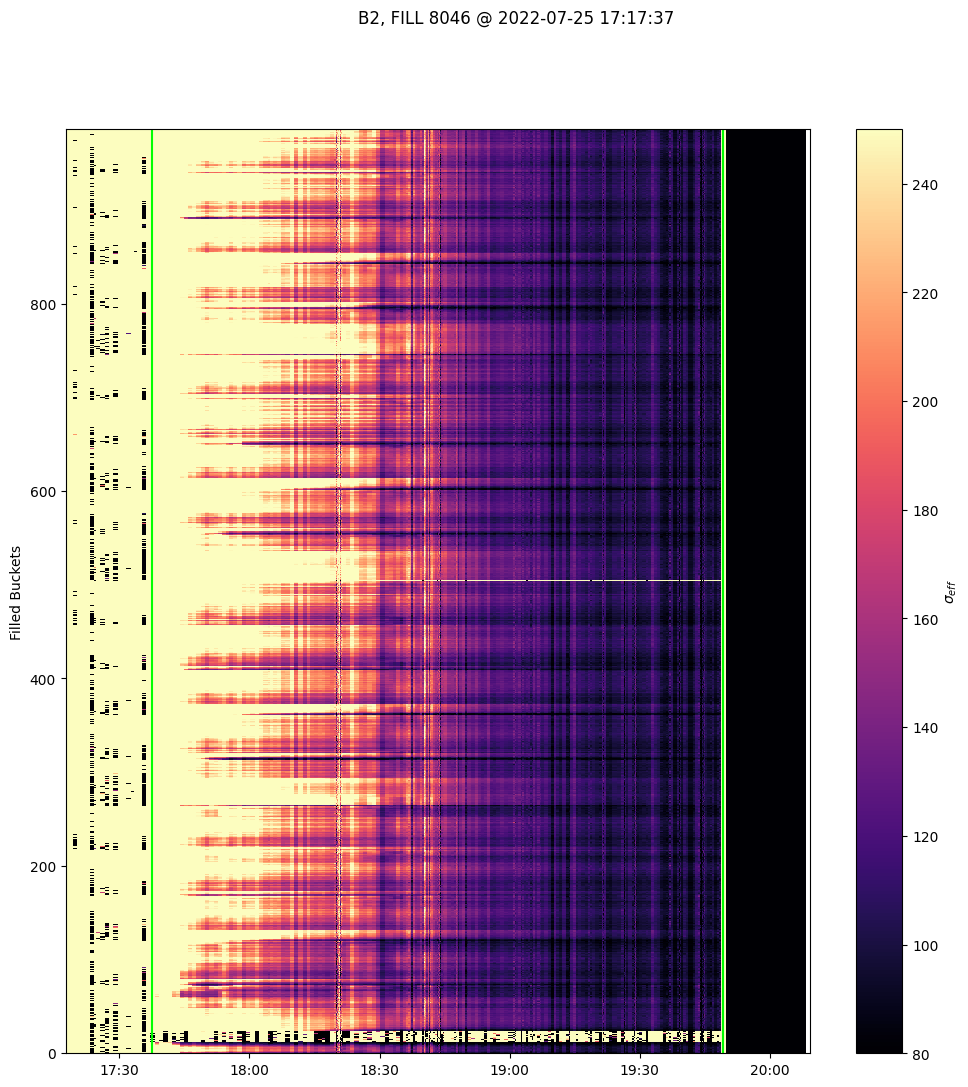

In [9]:


def compute_xsection_avg(df,beam):

    
    # Extracting quantities:
    #----------------------------------------
    # Luminosity is measured every minute, let's use it without too much manipulations
    times = df.set_index('Time')['bb_LUMI_TOT'].dropna().index
    bins  = np.diff(times)/2 + times[:-1]

    observable     = beam['bb_Intensity']
    times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].to_2D()

    observable  = 'bb_LUMI_TOT'
    _,data_L    = df.set_index('Time')[observable].to_2D()
    data_L      = 1e6*data_L[2:-2,:]
    times       = times[2:-2]
    #----------------------------------------

    # Aligning times with interpolation
    #---------------------------------
    data_N = interp1d(times_N,data_N,axis=0)(times)
    #---------------------------------

    # Computing xsection and lifetime
    #---------------------------------
    dNdt      = np.diff(data_N,axis=0)/np.tile(np.diff(times),(np.shape(data_N)[1],1)).T
    xsection  = -dNdt/data_L[:-1,:]
    
    
    #---------------------------------


    # UNPACKING RESULTS
    bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]


    return pd.DataFrame({'Time':times[:-1],'Timestamp':bin_timestamp[:-1],'sig_c':list(xsection)},index=bin_unix[:-1])



vmin = 80
vmax = 250

for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_xsection_avg(database,beam)

    # saving results
    if SAVING:
        lifetime_df.to_pickle(f"../Results_Lumi_bb/{SAVEPKL}/Xsection_F{FILL}_{beam.name}.pkl")  
    
    times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()

    #datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,vmin=vmin, vmax=vmax,cmap='magma')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')

    cbar = plt.colorbar()
    cbar.set_label(r'$\sigma_{eff}$')
    plt.ylabel('Bunch Buckets')
    plt.xlim([start_ts,stop_ts])



for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    
    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_xsection_avg(database,beam)
    
    times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()

    datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,vmin=vmin,vmax=vmax,cmap='magma')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')

    cbar = plt.colorbar()
    cbar.set_label(r'$\sigma_{eff}$')
    plt.ylabel('Filled Buckets')
    plt.xlim([start_ts,stop_ts])
    #plt.xlim([start_ts,pd.Timestamp('2022-08-20 12:00').tz_localize('UTC')])

# Discrete colors



/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarn

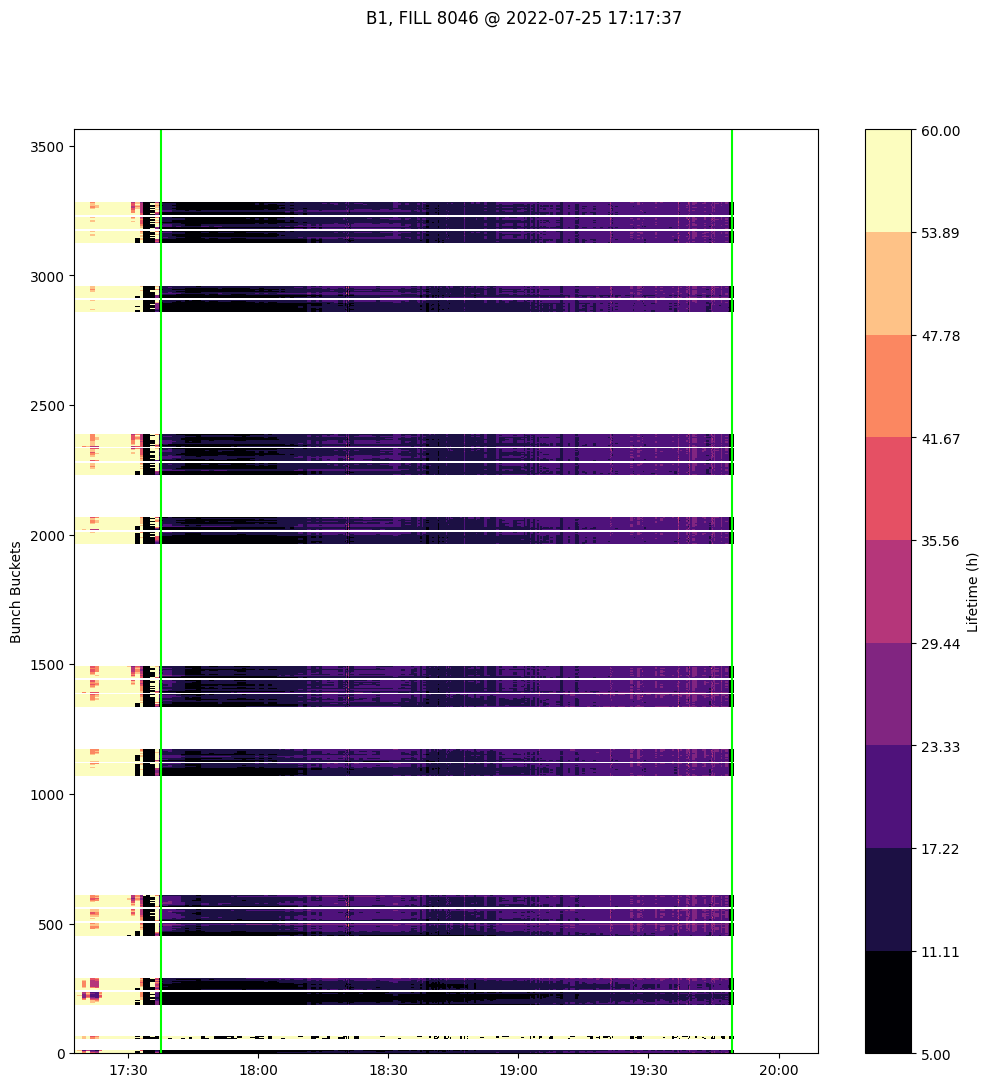

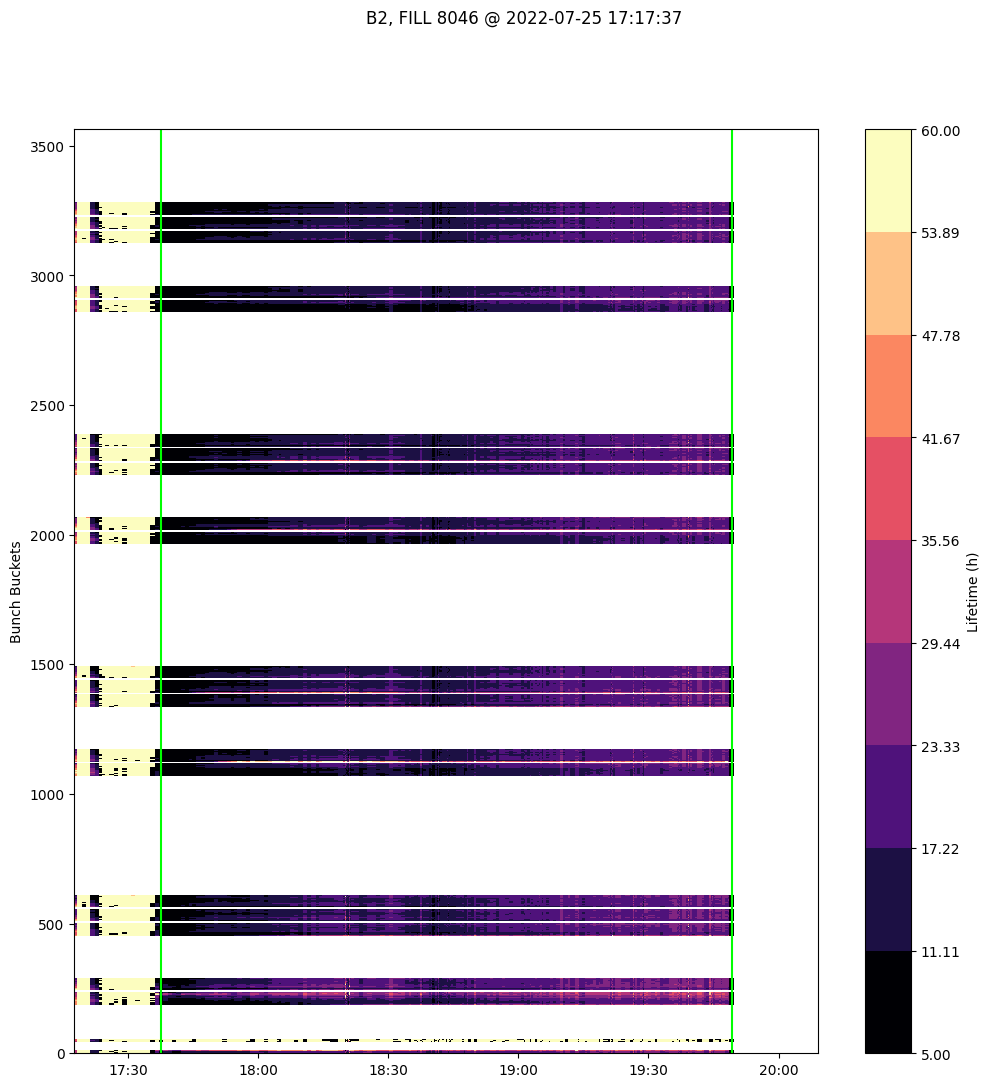

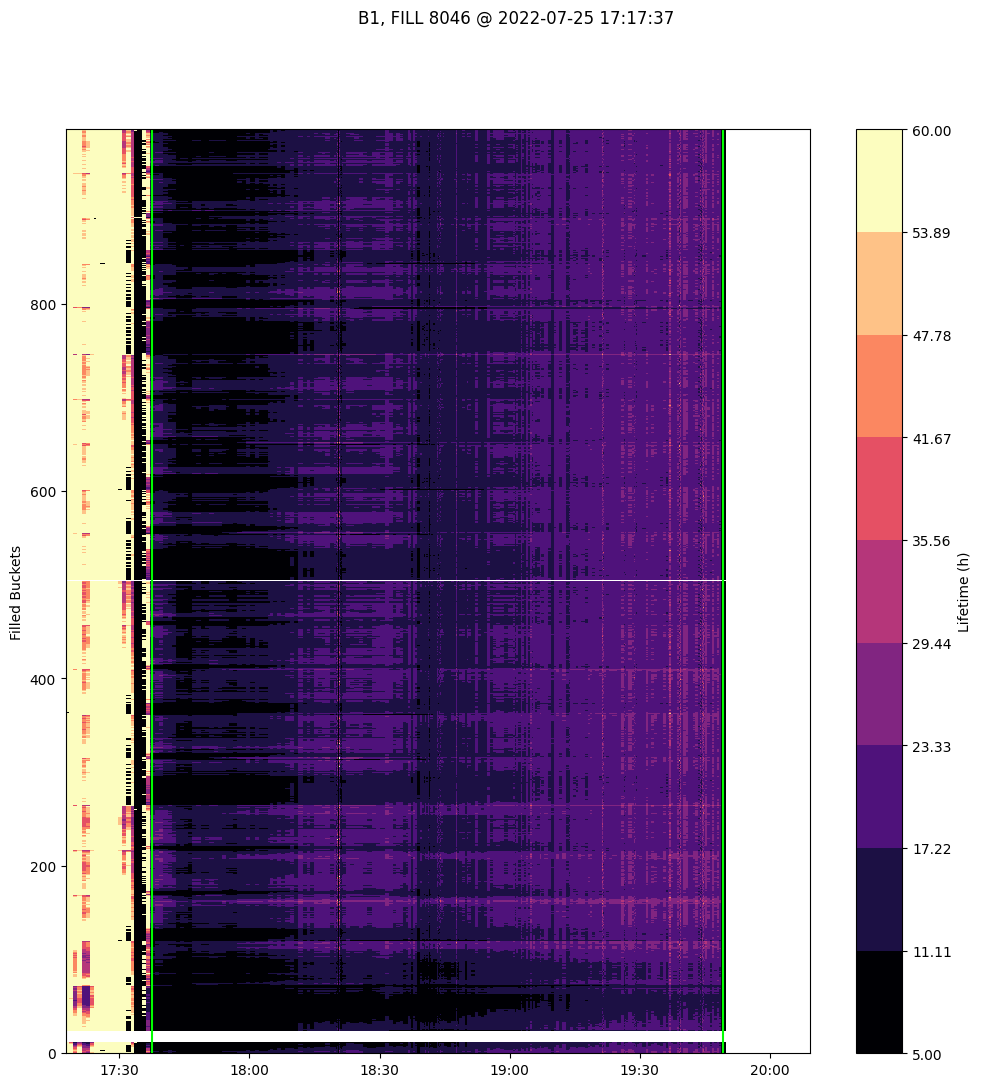

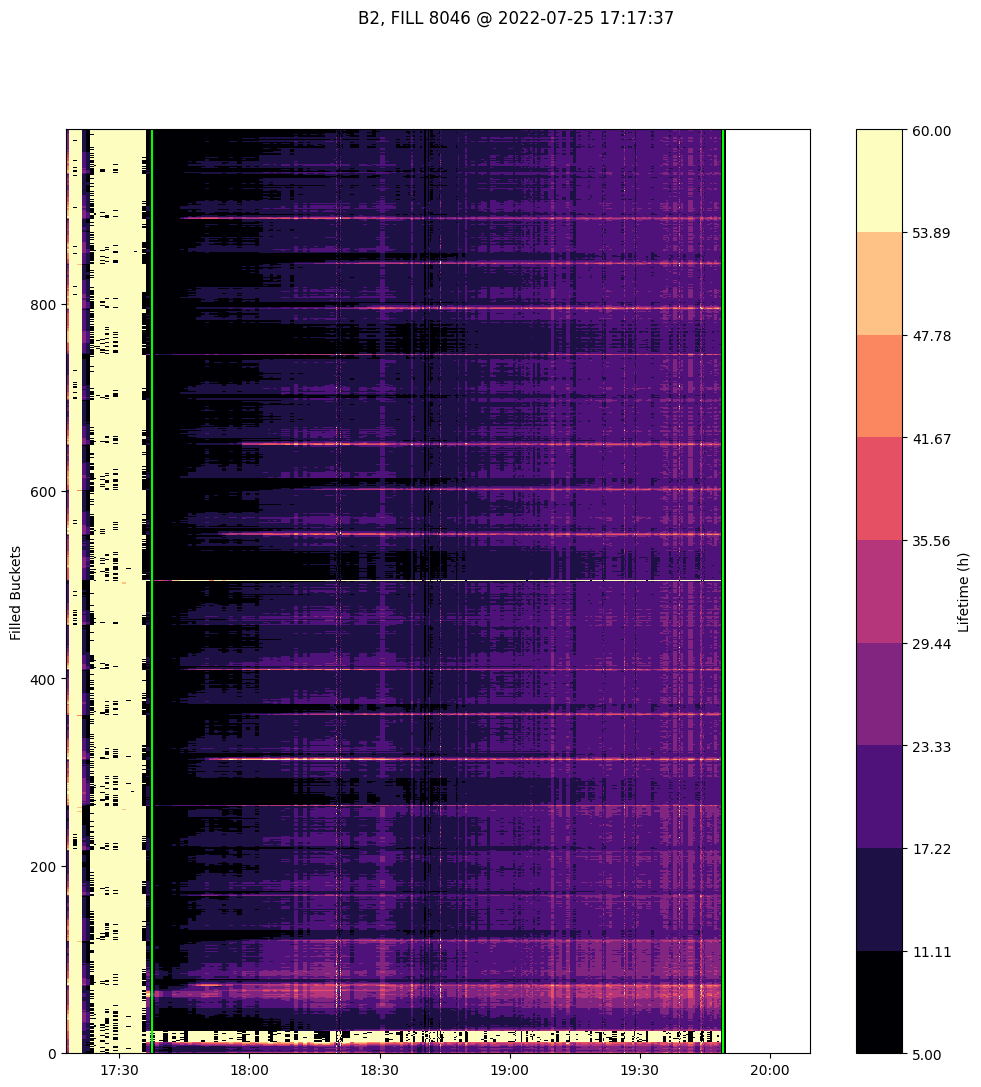

In [10]:
def compute_lifetime_avg(df,beam):

    
    # Extracting quantities:
    #----------------------------------------
    # Luminosity is measured every minute, let's use it without too much manipulations
    times = df.set_index('Time')['bb_LUMI_TOT'].dropna().index
    bins  = np.diff(times)/2 + times[:-1]

    observable     = beam['bb_Intensity']
    times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].to_2D()

    observable  = 'bb_LUMI_TOT'
    _,data_L    = df.set_index('Time')[observable].to_2D()
    data_L      = 1e6*data_L[2:-2,:]
    times       = times[2:-2]
    #----------------------------------------

    # Aligning times with interpolation
    #---------------------------------
    data_N = interp1d(times_N,data_N,axis=0)(times)
    #---------------------------------

    # Computing xsection and lifetime
    #---------------------------------
    dNdt      = np.diff(data_N,axis=0)/np.tile(np.diff(times),(np.shape(data_N)[1],1)).T
    #xsection  = -dNdt/data_L[:-1,:]
    #N0        = np.tile(data_N[0,:],(np.shape(data_N)[0],1))
    lifetime  = -data_N[:-1,:]/dNdt
    #---------------------------------


    # UNPACKING RESULTS
    bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]


    return pd.DataFrame({'Time':times[:-1],'Timestamp':bin_timestamp[:-1],'Lifetime':list(lifetime)},index=bin_unix[:-1])



from matplotlib.colors import LogNorm,SymLogNorm,TwoSlopeNorm,BoundaryNorm
cmap = plt.cm.magma

colorBounds = list(np.linspace(5,60,10)) 
colorList =  cmap(np.linspace(0.1, 0.9,len(colorBounds)-1))


for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_lifetime_avg(database,beam)
    
    times,datagrid = lifetime_df.set_index('Timestamp')['Lifetime'].to_2D()

    #datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/3600,cmap=cmap,norm=BoundaryNorm(boundaries=colorBounds, ncolors=256))
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    cbar = plt.colorbar()
    cbar.set_label('Lifetime (h)')
    plt.ylabel('Bunch Buckets')
    plt.xlim([start_ts,stop_ts])

for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    
    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_lifetime_avg(database,beam)
    
    times,datagrid = lifetime_df.set_index('Timestamp')['Lifetime'].to_2D()

    datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/3600,cmap=cmap,norm=BoundaryNorm(boundaries=colorBounds, ncolors=256))
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    cbar = plt.colorbar()
    cbar.set_label('Lifetime (h)')
    plt.ylabel('Filled Buckets')
    plt.xlim([start_ts,stop_ts])



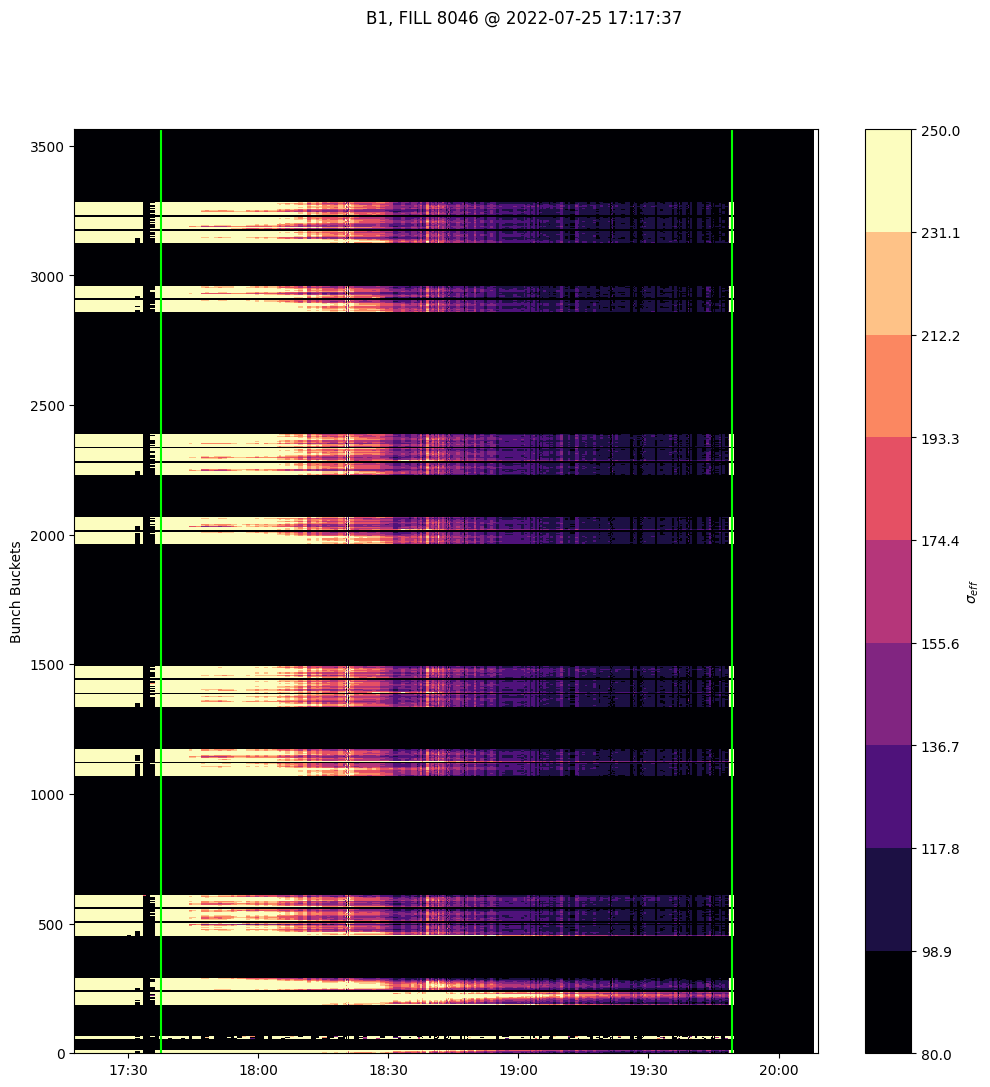

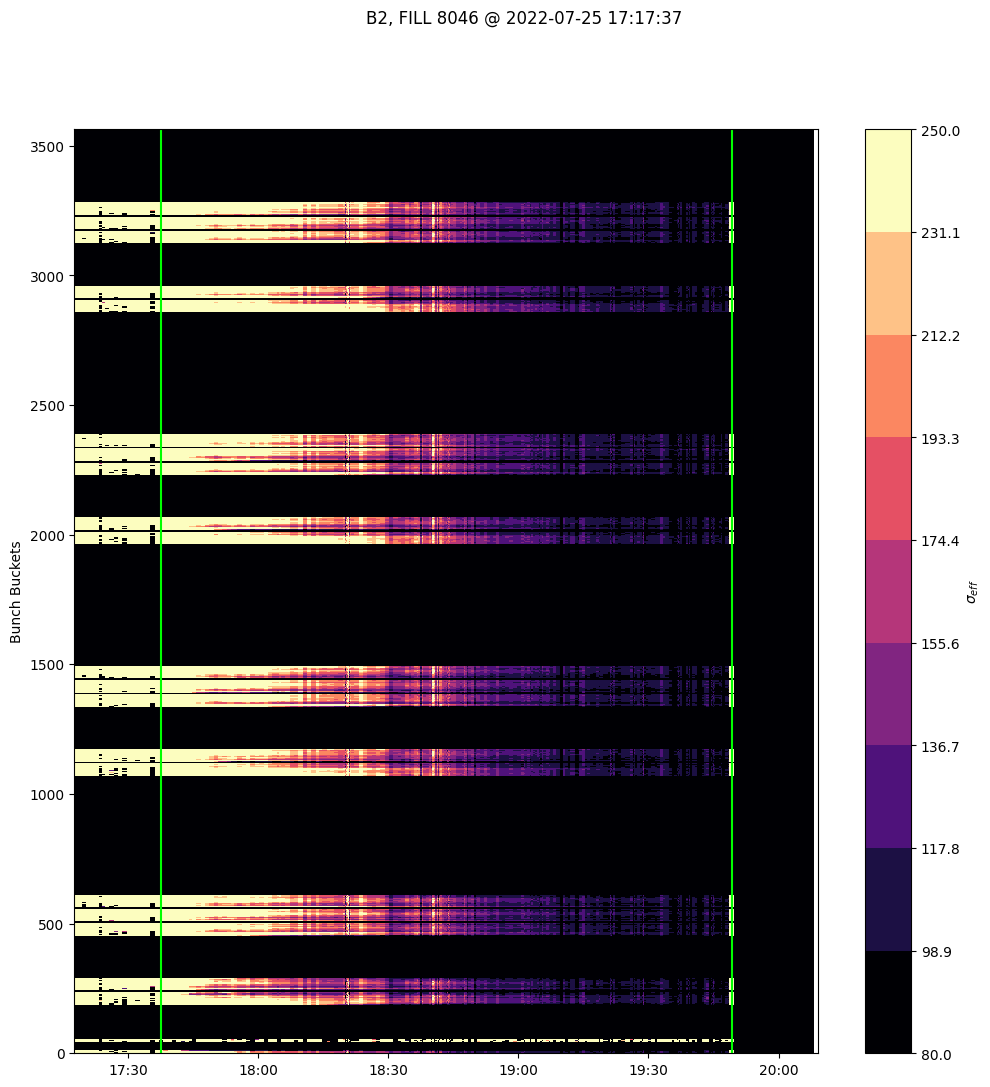

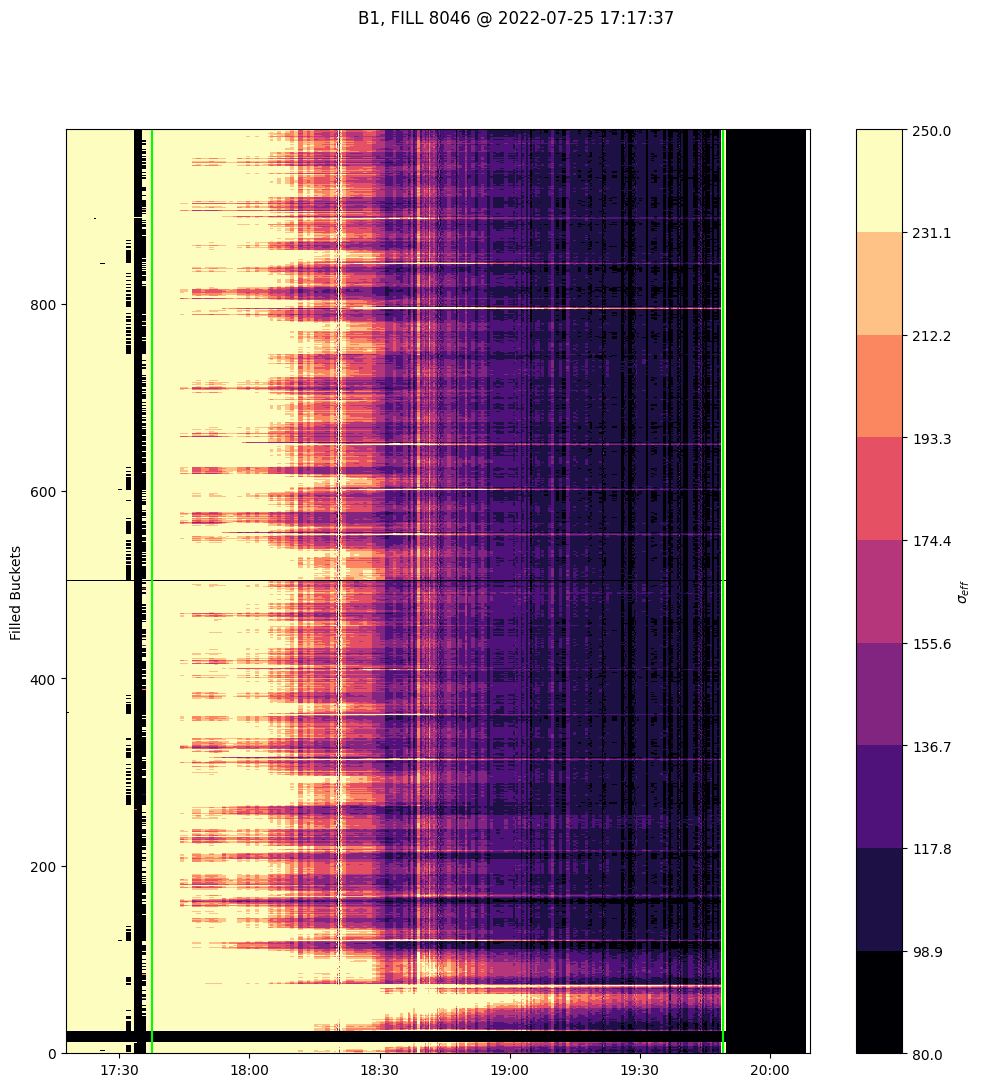

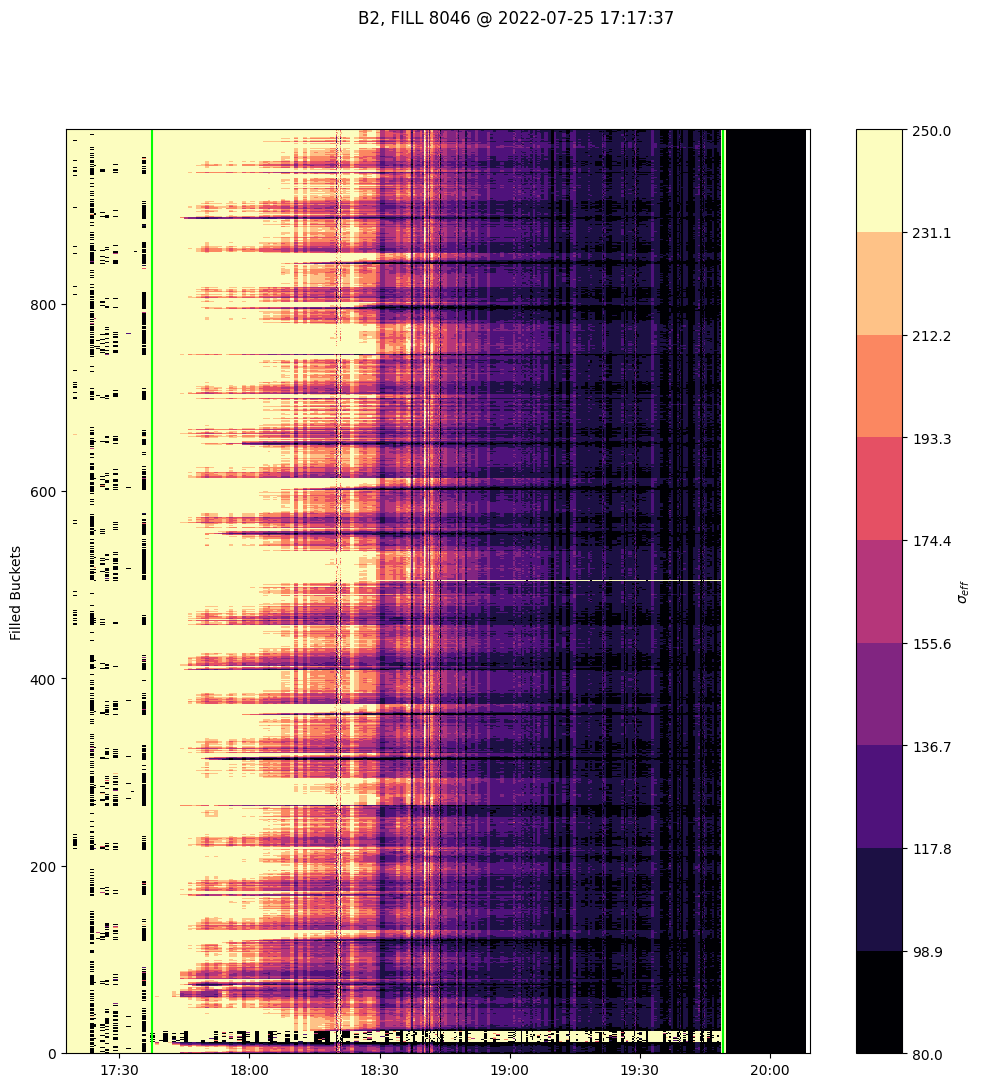

In [11]:

def compute_xsection_avg(df,beam):

    
    # Extracting quantities:
    #----------------------------------------
    # Luminosity is measured every minute, let's use it without too much manipulations
    times = df.set_index('Time')['bb_LUMI_TOT'].dropna().index
    bins  = np.diff(times)/2 + times[:-1]

    observable     = beam['bb_Intensity']
    times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].to_2D()

    observable  = 'bb_LUMI_TOT'
    _,data_L    = df.set_index('Time')[observable].to_2D()
    data_L      = 1e6*data_L[2:-2,:]
    times       = times[2:-2]
    #----------------------------------------

    # Aligning times with interpolation
    #---------------------------------
    data_N = interp1d(times_N,data_N,axis=0)(times)
    #---------------------------------

    # Computing xsection and lifetime
    #---------------------------------
    dNdt      = np.diff(data_N,axis=0)/np.tile(np.diff(times),(np.shape(data_N)[1],1)).T
    xsection  = -dNdt/data_L[:-1,:]
    
    
    #---------------------------------


    # UNPACKING RESULTS
    bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]


    return pd.DataFrame({'Time':times[:-1],'Timestamp':bin_timestamp[:-1],'sig_c':list(xsection)},index=bin_unix[:-1])

from matplotlib.colors import LogNorm,SymLogNorm,TwoSlopeNorm,BoundaryNorm
cmap = plt.cm.magma

colorBounds = list(np.linspace(80,250,10)) 
colorList =  cmap(np.linspace(0.1, 0.9,len(colorBounds)-1))



for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    
    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_xsection_avg(database,beam)
    
    times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()

    #datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,cmap=cmap,norm=BoundaryNorm(boundaries=colorBounds, ncolors=256))
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    cbar = plt.colorbar()
    cbar.set_label(r'$\sigma_{eff}$')
    plt.ylabel('Bunch Buckets')
    plt.xlim([start_ts,stop_ts])



for beam in beams:
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    filled_buckets = np.arange(len(buckets))[bunch_I!=0]
    
    lifetime_df = compute_xsection_avg(database,beam)
    
    times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()

    datagrid = datagrid[:,filled_buckets]
    
    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,cmap=cmap,norm=BoundaryNorm(boundaries=colorBounds, ncolors=256))
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    cbar = plt.colorbar()
    cbar.set_label(r'$\sigma_{eff}$')
    plt.ylabel('Filled Buckets')
    plt.xlim([start_ts,stop_ts])

# Current plot
